In [25]:
#PCA METHOD WITH REPORTING
import pandas as pd
import numpy as np
import math
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def reduce_pca_by_variance(data: np.ndarray, feature_names: list, variance_threshold: float):
    """
    Performs PCA on n-dimensional data, automatically selecting the minimum
    number of components to explain at least the `variance_threshold`.
    
    This modified version also prints the results of the reduction and
    the top 5 feature contributors for each component.

    Args:
        data: A (n_samples, n_features) NumPy array.
        feature_names: A list of strings corresponding to the feature columns
                       in `data`. (e.g., list(df.columns))
        variance_threshold: The target amount of variance to explain
                            (e.g., 0.95 for 95%).

    Returns:
        A tuple containing:
        - data_transformed (np.ndarray): The data projected onto the
                                         new component space.
        - fitted_pca (PCA): The fitted PCA object, which you can use
                            to inspect the number of components, etc.
        - explained_variance_list (list): A list of the variance explained
                                          by each component (e.g., [0.5, 0.3]).
    """
    
    if len(feature_names) != data.shape[1]:
        raise ValueError(f"Number of feature_names ({len(feature_names)}) does not "
                         f"match number of data columns ({data.shape[1]}).")

    # 1. Create a PCA object with the variance threshold.
    # By setting n_components to a float, PCA automatically finds
    # the components needed to explain that much variance.
    pca = PCA(n_components=variance_threshold)
    
    # 2. Create a pipeline to first scale the data, then run PCA.
    # Scaling is crucial for PCA to work correctly.
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', pca)
    ])
    
    # 3. Fit the pipeline to the data and transform it
    data_transformed = pipeline.fit_transform(data)
    
    # --- Report print statements ---
    
    # Get the original and new dimensions
    original_dimensions = data.shape[1]
    # We access the fitted pca object from step 2
    new_dimensions = pca.n_components_ 
    
    print("-" * 30)
    print("PCA Dimensionality Reduction Report")
    print("-" * 30)
    print(f"Original dimensions:   {original_dimensions}")
    print(f"New dimensions:        {new_dimensions}")
    print(f"Dimensions reduced by: {original_dimensions - new_dimensions}")
    print("\nVariance explained by each remaining component:")
    
    # pca.explained_variance_ratio_ is an array like [0.5, 0.3, 0.1]
    for i, variance in enumerate(pca.explained_variance_ratio_):
        print(f"  Principal Component {i+1}: {variance * 100:.2f}%")
        
    # Print total variance explained
    total_variance = np.sum(pca.explained_variance_ratio_)
    print(f"\nTotal variance explained: {total_variance * 100:.2f}%")
    print(f"(Target threshold was {variance_threshold * 100:.0f}%)")
    
    # --- New: Top 5 Contributors per Component Report ---
    print("\nTop 5 Contributors per Component:")
    
    # pca.components_ has shape (n_components, n_features)
    for i, component in enumerate(pca.components_):
        print(f"  --- Principal Component {i+1} ---")
        
        # Get indices of the top 5 absolute loadings
        # np.argsort returns indices of smallest to largest
        # We take the last 5, and then reverse them [::-1]
        top_5_indices = np.argsort(np.abs(component))[-5:][::-1]
        
        # Print the feature name and its loading (weight)
        for j, feature_index in enumerate(top_5_indices):
            feature_name = feature_names[feature_index]
            loading = component[feature_index]
            print(f"    {j+1}. {feature_name}: {loading:.4f}")
            
    print("-" * 30)
    
    # --- End of report ---
    
    # Get the list of explained variances
    explained_variance_list = pca.explained_variance_ratio_.tolist()
    
    # Return the new data, the fitted PCA object, and the list of variances
    return data_transformed, pca, explained_variance_list


# Processing

In [26]:
# Get data to be a numpy array probably
df=pd.read_csv('consolidated_acs_data_clean.csv')
data=np.array(df)
income_index=1  # Example index for income dimension
# Transform the income dimension by logarithmic scale
data[:, income_index] = np.log(data[:, income_index].astype(np.float64))
# Normalize data by dividing by standard deviation by dimension
for i in range(1,data.shape[1]):
    data[:, i] = data[:, i] / np.std(data[:, i])


## Weighting

In [27]:
# Initilize weights, and scale data by weights
# Get column indices
income_index = 1  # per_capita_income
poverty_index = df.columns.get_loc('avg_poverty_ratio')
employment_index = df.columns.get_loc('in_labor_force')
healthcare_index = df.columns.get_loc('Educational services, and health care and social assistance')
education_index = df.columns.get_loc('College or More')
commute_index = df.columns.get_loc('avg_commute_time')
housing_index = df.columns.get_loc('avg_housing_cost_burden')
race_indices = [df.columns.get_loc(col) for col in ['white', 'black', 'asian', 'native', 'pacific islander', 'other']]

# Apply dimension weights
data[:, income_index] *= 0.1225          # Economic Security - Income
data[:, poverty_index] *= 0.0525         # Economic Security - Poverty
data[:, employment_index] *= 0.07        # Economic Security - Employment
data[:, healthcare_index] *= 0.105       # Economic Security - Healthcare
data[:, education_index] *= 0.15         # Education
data[:, commute_index] *= 0.15           # Location Affordability - Transportation
data[:, housing_index] *= 0.15           # Location Affordability - Housing

# Race: distribute 0.2 across 6 race columns
for idx in race_indices:
    data[:, idx] *= 0.2 / 6  # 0.0333 per column

weights = np.array([
    0.1225,     # 1:  per_capita_income (Economic Security - Income)
    0.2/6,      # 2:  white (Cultural - Race)
    0.2/6,      # 3:  black (Cultural - Race)
    0.2/6,      # 4:  asian (Cultural - Race)
    0.2/6,      # 5:  native (Cultural - Race)
    0.2/6,      # 6:  pacific islander (Cultural - Race)
    0.2/6,      # 7:  other (Cultural - Race)
    0.0,        # 8:  Under High School (not weighted)
    0.0,        # 9:  High School (No College Degree) (not weighted)
    0.15,       # 10: College or More (Education)
    0.0,        # 11: Agriculture (not weighted)
    0.0,        # 12: Construction_and_manufacturing (not weighted)
    0.0,        # 13: trade (not weighted)
    0.0,        # 14: Transportation and warehousing (not weighted)
    0.0,        # 15: nerds (not weighted)
    0.105,      # 16: Educational services, and health care (Economic Security - Healthcare)
    0.0,        # 17: finance_inurance_and_realty (not weighted)
    0.0,        # 18: other_services (not weighted)
    0.07,       # 19: in_labor_force (Economic Security - Employment)
    0.0,        # 20: out_labor_force (not weighted)
    0.15,       # 21: avg_commute_time (Location Affordability - Transportation)
    0.15,       # 22: avg_housing_cost_burden (Location Affordability - Housing)
    0.0525,     # 23: avg_poverty_ratio (Economic Security - Poverty)
])


In [28]:
# Perform PCA, and project onto the top N dimensions so that they explain 50% of the variance
new_data,pca,var_explained = reduce_pca_by_variance(data[:,1:], list(df.columns)[1:], variance_threshold=0.5)

------------------------------
PCA Dimensionality Reduction Report
------------------------------
Original dimensions:   23
New dimensions:        6
Dimensions reduced by: 17

Variance explained by each remaining component:
  Principal Component 1: 16.07%
  Principal Component 2: 10.11%
  Principal Component 3: 8.43%
  Principal Component 4: 6.79%
  Principal Component 5: 6.32%
  Principal Component 6: 5.67%

Total variance explained: 53.38%
(Target threshold was 50%)

Top 5 Contributors per Component:
  --- Principal Component 1 ---
    1. College or More: 0.4448
    2. avg_poverty_ratio: 0.3872
    3. Under High School: -0.3443
    4. per_capita_income: 0.2592
    5. in_labor_force: 0.2370
  --- Principal Component 2 ---
    1. out_labor_force: -0.4101
    2. in_labor_force: 0.4101
    3. white: -0.3803
    4. pacific islander: -0.3752
    5. Agriculture, forestry, fishing and hunting, and mining: -0.2772
  --- Principal Component 3 ---
    1. High School (No College Degree): 0.4196


As shown, the first component has a distinct identity, namely education, income and poverty, part of the most important factors typically considered as determinant of a person's sociol-economic status. The rest of the components are a mixed of race, education, occupation, and comute time.

# Network initialization

In [29]:
def create_dimension_layered_knn(data, dimension_weights, k=10):
    """
    Create multi-layer network where each dimension has its own KNN graph.
    """
    G = nx.Graph()
    
    # Add nodes
    for i in range(data.shape[0]):
        G.add_node(i)
    
    # For each dimension, create KNN graph
    for dim in range(data.shape[1]):
        dim_weight = dimension_weights[dim]
        
        if dim_weight == 0:
            continue
        
        # Get this dimension's values (1D)
        dim_data = data[:, dim].reshape(-1, 1)
        
        # Build KNN graph for THIS dimension only
        from sklearn.neighbors import NearestNeighbors
        nbrs = NearestNeighbors(n_neighbors=k)
        nbrs.fit(dim_data)
        distances, indices = nbrs.kneighbors(dim_data)
        
        # Add edges weighted by dimension importance
        for i in range(len(data)):
            for j, neighbor in enumerate(indices[i]):
                if i != neighbor:
                    if G.has_edge(i, neighbor):
                        G[i][neighbor]['weight'] += dim_weight  # Accumulate
                    else:
                        G.add_edge(i, neighbor, weight=dim_weight)
    
    return G


In [30]:
# from ring_network import construct_net
G = create_dimension_layered_knn(new_data, dimension_weights=var_explained, k=10)
G_uni= nx.Graph()
G_uni.add_nodes_from(G.nodes(data=True))
G_uni.add_edges_from(G.edges())

# Gring= construct_net(new_data,var_explained,0.2)
# Gring_uni= nx.Graph()
# Gring_uni.add_nodes_from(Gring.nodes(data=True))
# Gring_uni.add_edges_from(Gring.edges())

## Geographic weighting

In [31]:
import pickle
from scipy.sparse import load_npz

# Create graph
Geo = G.copy()
GeoPure = nx.Graph()
#Gring_geo=Gring.copy()
# Load adjacency matrix
adj_matrix = load_npz('adjacency_queen_matrix.npz')

# Load mappings
with open('adjacency_queen_mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)
index_to_geoid = mappings['index_to_geoid']

# Get edges from sparse matrix
rows, cols = adj_matrix.nonzero()

# Add edges with your weight
weight = 2  # Change this to your desired weight

for i, j in zip(rows, cols):
    if i < j:  # Only add each edge once (undirected)
        geoid1 = index_to_geoid[i]
        geoid2 = index_to_geoid[j]
        Geo.add_edge(i, j, weight=weight)
        #Gring_geo.add_edge(i, j, weight=weight)
        GeoPure.add_edge(i, j, weight=weight)


# Grouping

In [32]:
# K means clustering function
from sklearn.cluster import KMeans

def get_kmeans_partition(data: np.ndarray, weights, n_clusters=14):
    """
    Runs K-means clustering on the input data and returns the loss
    (inertia) and a partition of the data indices by cluster.

    Args:
        data: A (n_samples, n_features) NumPy array.
        n_clusters: The number of clusters (k).

    Returns:
        A tuple containing:
        - loss (float): The inertia (Within-Cluster Sum of Squares).
        - partitions (dict): A dictionary where keys are cluster IDs (0 to k-1)
                             and values are lists of original data indices
                             belonging to that cluster.
    """
    
    # 1. Initialize and fit the K-means model
    # n_init=10 runs the algorithm 10 times and picks the best result
    # random_state=42 ensures the result is reproducible
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    for i in range(len(weights)):
        data[:, i] = data[:, i] * weights[i]
    kmeans.fit(data)

    # 2. Get the loss (inertia)
    # .inertia_ is the WCSS (Within-Cluster Sum of Squares)
    loss = kmeans.inertia_

    # 3. Get the cluster assignment for each data point
    # .labels_ is an array like [0, 1, 1, 0, 2, ...]
    labels = kmeans.labels_

    # 4. Create the partition of indices
    partitions = {i: [] for i in range(n_clusters)}
    for index, cluster_id in enumerate(labels):
        partitions[cluster_id].append(index)

    return loss, partitions

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

def calculate_kmeans_loss_for_partition(data: np.ndarray, partition: list) -> float:
    """
    Calculates the K-means "loss" (Inertia, or Within-Cluster Sum of Squares)
    for a given dataset and a user-provided partition.

    Args:
        data: A (n_samples, n_features) NumPy array.
        partition: A list of lists, where each inner list contains the
                   *indices* (row numbers) of the data points belonging
                   to that cluster.
                   Example: [[0, 1, 4], [2, 3, 5]]

    Returns:
        total_loss (float): The total K-means loss (Inertia) for this partition.
    """
    
    total_loss = 0.0

    # Iterate over each cluster (which is a list of indices)
    for indices in partition:
        
        # 1. Get all data points belonging to this cluster
        # Using [indices, :] selects all rows whose index is in the list
        cluster_points = data[indices, :]
        
        # Handle empty clusters (their loss is 0)
        if cluster_points.shape[0] == 0:
            continue
            
        # 2. Calculate the "true" centroid (mean) for this cluster
        # axis=0 calculates the mean of each *column* (feature)
        centroid = np.mean(cluster_points, axis=0)
        
        # 3. Calculate the sum of squared distances from each point to the centroid
        #    - (cluster_points - centroid) uses broadcasting to get distance vectors
        #    - (** 2) squares all distances
        #    - np.sum(...) sums all squared distances into a single number
        cluster_loss = np.sum((cluster_points - centroid) ** 2)
        
        # 4. Add this cluster's loss to the total
        total_loss += cluster_loss
        
    return total_loss


k = 14

# 3. Run the function
total_loss, index_partitions = get_kmeans_partition(new_data,weights=var_explained, n_clusters=k)

index_partitions=[index_partitions[i] for i in range(k)]

KeyboardInterrupt: 

In [ ]:
partG=nx.algorithms.community.louvain_communities(G,weight='weight',resolution=0.75)
print("Number of Louvain communities G:",len(partG))
partGeo=nx.algorithms.community.louvain_communities(Geo,weight='weight',resolution=0.8)
print("Number of Louvain communities Geo:",len(partGeo))
partG_uni=nx.algorithms.community.louvain_communities(G_uni,weight='weight',resolution=0.95)
print("Number of Louvain communities G_uni:",len(partG_uni))

# partGring=nx.algorithms.community.louvain_communities(Gring,weight='weight',resolution=0.65)
# print("Number of Louvain communities ring:",len(partGring))
# partRing_geo=nx.algorithms.community.louvain_communities(Gring_geo,weight='weight',resolution=0.7)
# print("Number of Louvain communities ring geo:",len(partRing_geo))
# partRing_uni=nx.algorithms.community.louvain_communities(Gring_uni,resolution=0.75)
# print("Number of Louvain communities ring uni:",len(partRing_uni))

Number of Louvain communities G: 16
Number of Louvain communities Geo: 20
Number of Louvain communities G_uni: 17


In [ ]:
partGeoPure=nx.algorithms.community.louvain_communities(GeoPure,weight='weight',resolution=0.25)
print("Number of Louvain communities GeoPure:",len(partGeoPure))

Number of Louvain communities GeoPure: 14


In [ ]:
print(np.std([len(x) for x in partGeo]))

108.6254459139294


In [ ]:
print("\n 10Graph Comparisons")
print("Louvain modularity G:",nx.algorithms.community.modularity(G, partG, weight='weight'))
print("Louvain modularity Geo partition on G:",nx.algorithms.community.modularity(Geo, partGeo, weight='weight'))
print("Louvain modularity Uni partition on G:",nx.algorithms.community.modularity(G, partG_uni, weight='weight'))

# print("\n Ring Comparisons")
# print("Louvain modularity ring:",nx.algorithms.community.modularity(Gring, partGring, weight='weight'))
# print("Louvain modularity Geo partition on ring:",nx.algorithms.community.modularity(Gring, partRing_geo, weight='weight'))
# print("Louvain modularity Uni partition on Gring:",nx.algorithms.community.modularity(Gring, partRing_uni, weight='weight'))

print("\n K Means Comparisons")
print("K means modularity on G:",nx.algorithms.community.modularity(G, index_partitions, weight='weight'))
# print("K means modularity on ring:",nx.algorithms.community.modularity(Gring, index_partitions, weight='weight'))


 10Graph Comparisons
Louvain modularity G: 0.2854726425486487
Louvain modularity Geo partition on G: 0.5172667612803135
Louvain modularity Uni partition on G: 0.15530941048958513

 K Means Comparisons
K means modularity on G: 0.10560605648755782


In [ ]:

# 1. Load your real data (as you were before)

# 2. Get your partition
# (e.g., from K-means, Louvain, or any other method)
# This is just a placeholder example!
# You would have your *real* partition here.

# 3. Set the path to the shapefile you downloaded
# (Update this path to where you unzipped the file)
SHAPEFILE = "tl_2020_37_tract/tl_2020_37_tract.shp"

# 4. Call the plotting function
# from plot_geo import *
# plot_partition_geographically(data, partGeo, SHAPEFILE)

In [ ]:
# color=[0]*data.shape[0]
# for i in range(len(partition)):
#     for o in partition[i]:
#         color[o]=i
# nx.draw(G,node_color=color,node_size=1)
# pos = nx.spring_layout(G, seed=42)
# nx.draw_networkx_nodes(G, pos, node_color=color, node_size=1)
# nx.draw_networkx_edges(G, pos, edge_color='black', alpha=0.1)

In [37]:
from typing import List, Set, Dict, Tuple
import time

# --- Helper Functions ---

def mean_variance(group,node,new_data,weights):
    n=len(group)
    var=0
    for i in range(new_data.shape[1]):
        weight=weights[i]
        dif=[new_data[node,i]-new_data[member,i] for member in group]
        var+=weight*sum(x**2 for x in dif)/n
    return var

def partition_to_map(partition: List[Set[int]]) -> Dict[int, int]:
    """Converts a list of sets to a dictionary mapping node -> community_index."""
    node_to_community = {}
    for i, community_set in enumerate(partition):
        for node in community_set:
            node_to_community[node] = i
    return node_to_community

def is_contiguous(G: nx.Graph, partition: List) -> bool:
    for part in partition:
        if not nx.is_connected(G.subgraph(part)):
            return False
    return True

def is_contiguous(G: nx.Graph, groupA: Set, groupB: Set) -> bool:
    """
    Checks if the two prospective communities (groupA and groupB) are contiguous
    in the geographical graph G.
    """
    # Check contiguity for groupA
    # Only check if the group has more than one node
    if len(groupA) > 1 and not nx.is_connected(G.subgraph(groupA)):
        return False
    # Check contiguity for groupB
    if len(groupB) > 1 and not nx.is_connected(G.subgraph(groupB)):
        return False
    return True

def sequential_swap(G: nx.Graph, Geo: nx.Graph, current_partition: List[Set[int]]) -> Tuple[List[Set[int]], float]:
    
    iteration_time = time.time()
    swap_count = 0
    swap_flag = False

    best_part = [set(comm) for comm in current_partition]
    node_to_community_map = partition_to_map(best_part)


    # 2. Iterate through each district (community)
    # We use a list of indices to ensure we iterate over all districts
    district_indices = list(range(len(best_part)))

    # 3. Iterate through each district
    for comm_A_idx in district_indices:
        # best_swap = None  # Stores: (node_A, node_B, comm_A_idx, comm_B_idx)
        
        district_A_nodes = best_part[comm_A_idx]
        
        # Identify all potential swap candidates involving a node from comm_A_idx
        # A swap candidate is a pair (A, B) where A is in comm_A_idx and B is adjacent to A
        # and B is in a different community comm_B_idx.
        
        # Iterate over all nodes A in the current district
        for node_A in district_A_nodes:

            if node_A not in best_part[comm_A_idx]:
                continue

            # Iterate over all geographical neighbors of A
            for node_B in Geo.neighbors(node_A):
                comm_B_idx = node_to_community_map.get(node_B)

                district_B_nodes = best_part[comm_B_idx]

                if comm_B_idx is None or comm_A_idx == comm_B_idx:
                    continue

                var_A_now = mean_variance(district_A_nodes,node_A,new_data,weights)
                var_B_now = mean_variance(district_B_nodes,node_B,new_data,weights)

                var_A_swap = mean_variance(district_A_nodes,node_B,new_data,weights)
                var_B_swap = mean_variance(district_B_nodes,node_A,new_data,weights)
                
                if var_A_swap + var_B_swap < var_A_now + var_B_now:
                    # print(f"Updating best swap. Swap variance {var_A_swap + var_B_swap} < Current variance {var_A_now + var_B_now}")
                    # Post-swap partition
                    # Simulate the swap for the contiguity check
                    prospective_part = [set(comm) for comm in best_part]

                    # Swap

                    # A leaves comm_A, B leaves comm_B
                    prospective_part[comm_A_idx].discard(node_A)
                    prospective_part[comm_B_idx].discard(node_B)

                    # A enters comm_B, B enters comm_A
                    prospective_part[comm_B_idx].add(node_A)
                    prospective_part[comm_A_idx].add(node_B)

                    # Check contiguity of two groups
                    
                    if is_contiguous(Geo,prospective_part[comm_A_idx], prospective_part[comm_B_idx]):
                        # Update best part
                        best_part = prospective_part
                        node_to_community_map = partition_to_map(best_part)
                        swap_count += 1
                        swap_flag = True
                        # print(f"Swap minimizes var, maintains contiguity. Node {node_A} and Node {node_B}.")
                        # print(f"Swap minimizes var, maintains contiguity. Swap Count: {swap_count}.")

    
    iteration_time = time.time() - iteration_time

    return best_part, iteration_time, swap_flag

In [ ]:
# --- Core Optimization Function with Sequential Swap and Delta Q ---
def optimized_sequential_swap(G: nx.Graph, Geo: nx.Graph, initial_partition: List[Set[int]], N_iterations: int) -> Tuple[List[Set[int]], float]:
    """
    Performs local search optimization using a sequential, targeted two-node swap.
    In each iteration, it finds the single best swap across all districts and executes it.
    """
    
    # 1. Pre-calculate initial community properties
    best_part = [set(comm) for comm in initial_partition] # current best partition
    
    # Calculate initial modularity score
    best_score = nx.algorithms.community.modularity(G, best_part, weight='weight')

    total_duration = time.time()
    
    print(f"Starting optimization with Modularity Score: {best_score:.4f}")
    
    # --- Main Optimization Loop ---
    for i in range(N_iterations):
        print(f"--- Iteration {i+1}/{N_iterations} ---")
        best_part, iter_time, swap_flag = sequential_swap(G, Geo, best_part)
        print(f"Iteration {i+1} complete. Time: {iter_time:.2f} seconds.")

        if not swap_flag:
            print("\nNo local swap increased modularity while maintaining contiguity. Optimization finished.")
            break
    
    total_duration = time.time() - total_duration

    # Calculate final modularity score
    # print(f"Length: {len(best_part)}")
    final_score = nx.algorithms.community.modularity(G, best_part, weight='weight')

    print("\n--- Final Results ---")
    print(f"Optimal Modularity Score (after local swaps): {final_score:.4f}")
    print(f"Optimization took: {total_duration:.2f} seconds")
    return best_part, final_score, total_duration

In [ ]:
N_iter = 100
best_partition, final_score, duration = optimized_sequential_swap(G, GeoPure, partGeoPure, N_iterations=N_iter)
print(f"Final Partition Size: {len(best_partition)}")
print(f"Final Modularity Score: {final_score}")
print(f"Optimization Time: {duration}")

# Problem: Stuck at local minima
# Try:
# 1. Multiple initial positions
# 2. Introduce noise via SGD
# 3. Taking uphill steps every so often, probability of uphill step decreases over iterations

Starting optimization with Modularity Score: 0.0100
--- Iteration 1/100 ---


KeyboardInterrupt: 

Loading shapefile...
Merging partition data with map...
Generating plot...
Done. Showing plot.


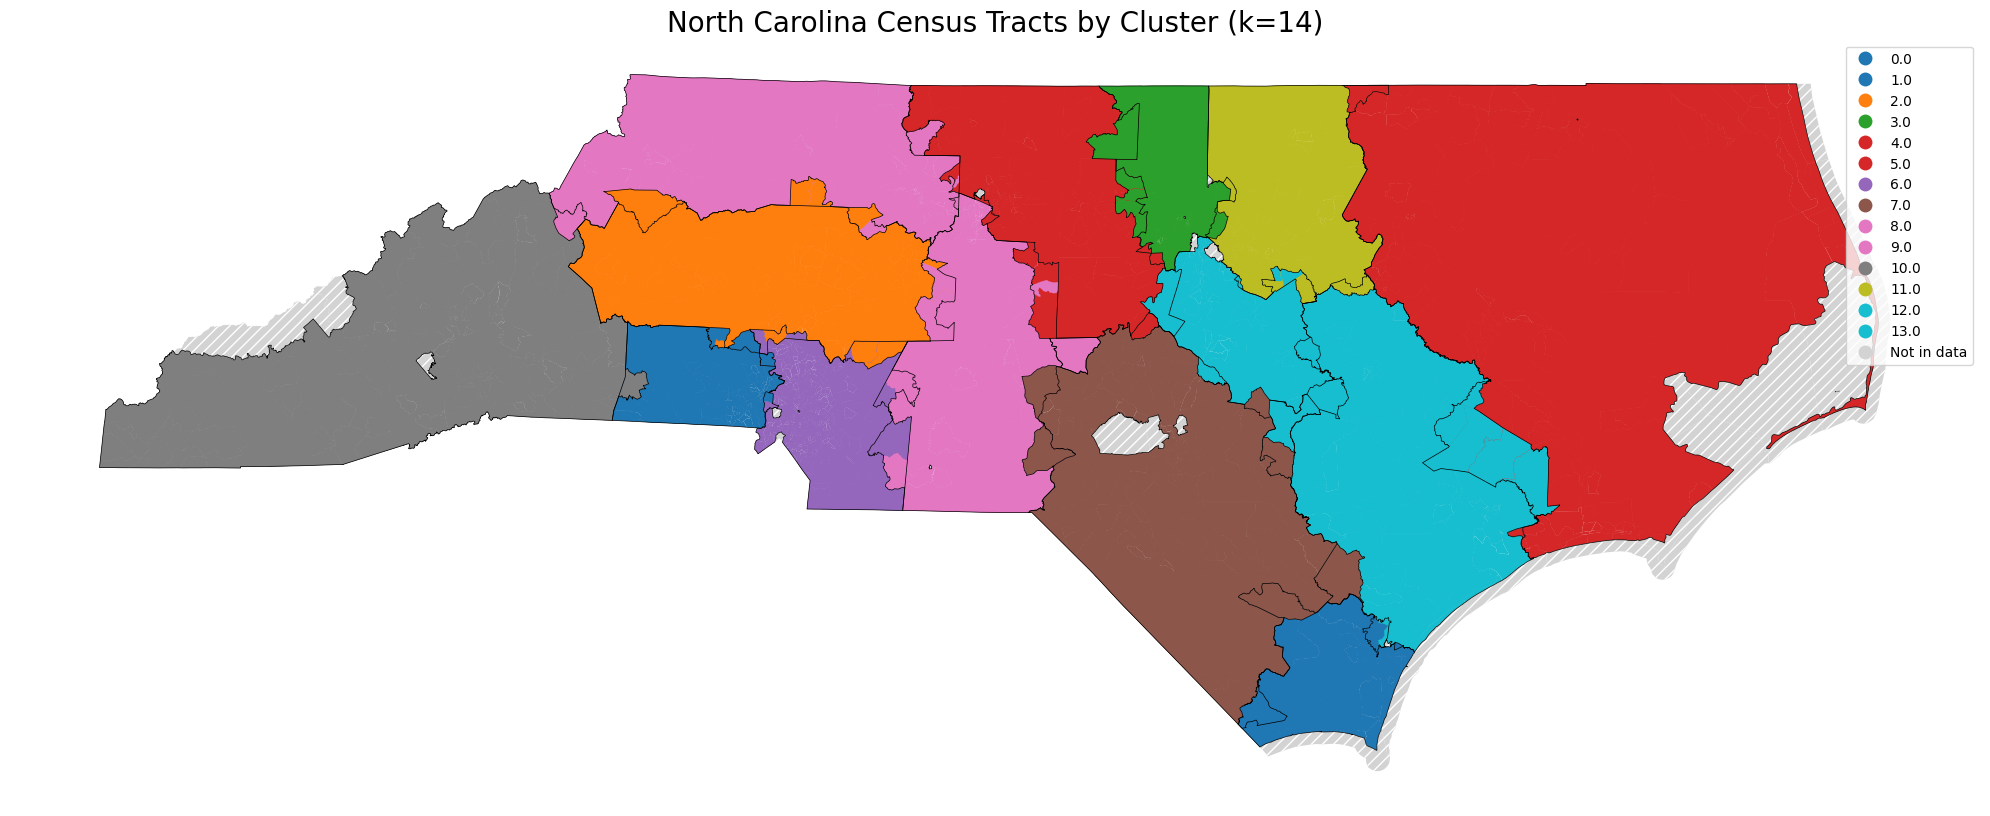

Loading shapefile...
Merging partition data with map...
Generating plot...
Done. Showing plot.


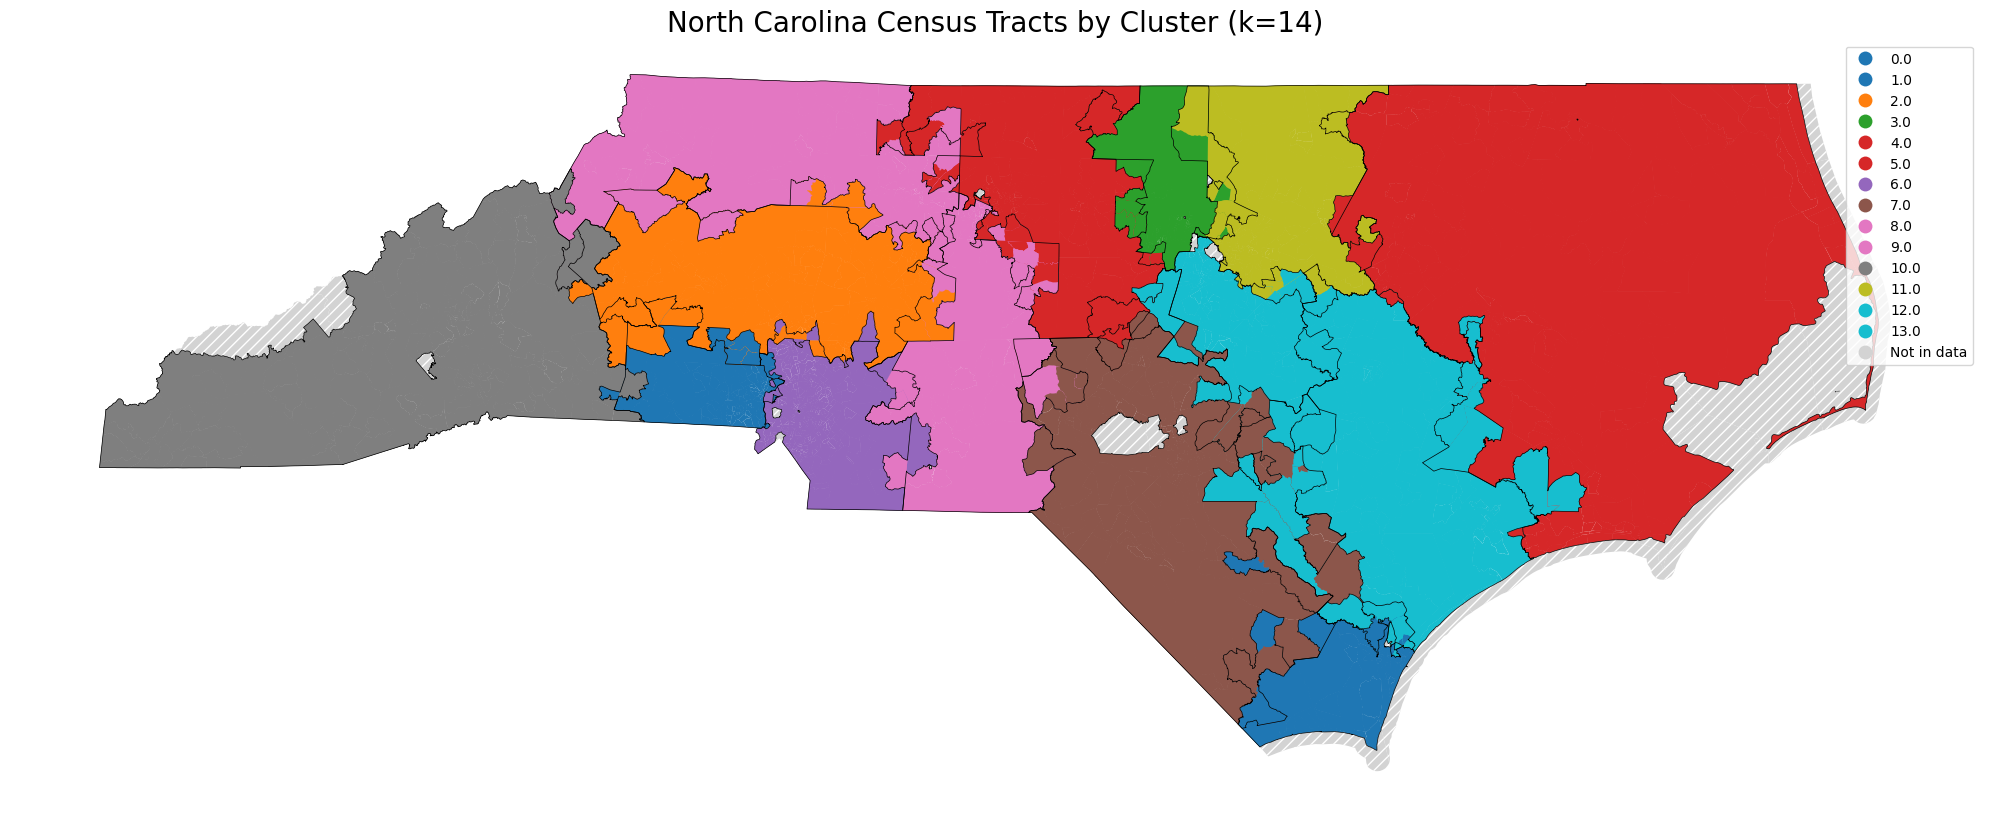

In [42]:
import plotly.express as px
from plot_geo import plot_partition_geographically

SHAPEFILE = "tl_2020_37_tract/tl_2020_37_tract.shp" 
# plot initial vs best to compare
plot_partition_geographically(data, partGeoPure, SHAPEFILE)
plot_partition_geographically(data, best_partition, SHAPEFILE)

In [ ]:
# Saving best partition

# Assuming 'best_partition' is the result from your optimization function
# and 'final_score' is the final modularity score.
# N_iter = 100
PARTITION_FILENAME = f'best_partition_{N_iter}_{final_score:.4f}.pkl'

# Save the partition and the final score to a file
with open(PARTITION_FILENAME, 'wb') as f:
    # We save a tuple containing both the partition and the score
    pickle.dump((best_partition, final_score), f)

print(f"Successfully saved the best partition and score to {PARTITION_FILENAME}")

Successfully saved the best partition and score to best_partition_1_0.0104.pkl


In [ ]:
# Loading saved partition

PARTITION_FILENAME = 'best_nc_partition.pkl'

try:
    with open(PARTITION_FILENAME, 'rb') as f:
        # Load the tuple back
        loaded_partition, loaded_score = pickle.load(f)
    
    print(f"Successfully loaded partition from {PARTITION_FILENAME}")
    print(f"Loaded Partition has {len(loaded_partition)} districts.")
    print(f"Loaded Modularity Score: {loaded_score:.4f}")
    
    # You can now use loaded_partition for plotting or further analysis
    # e.g., loaded_partition is your new 'best_partition'
    
except FileNotFoundError:
    print(f"Error: File {PARTITION_FILENAME} not found.")

Error: File best_nc_partition.pkl not found.
